In [6]:
import sys
sys.path.append("../scripts/")
from ideal_robot import *
from scipy.stats import expon, norm

In [11]:
class Robot(IdealRobot):
    def __init__(self, pose, agent=None, sensor=None, color="black", noise_per_meter=5, noise_std=math.pi/60):
        super().__init__(pose, agent, sensor, color)
        self.noise_pdf = expon(scale=1.0/(1e-100+noise_per_meter))
        self.distance_until_noise = self.noise_pdf.rvs()
        self.theta_noise = norm(scale=noise_std)
        
    def noise(self, pose, nu, omega, time_interval):
        self.distance_until_noise -= abs(nu) * time_interval + self.r * abs(omega) * time_interval
        # 小石を踏んだのでノイズをリセット
        if self.distance_until_noise <= 0.0:
            self.distance_until_noise += self.noise_pdf.rvs()
            pose[2] += self.theta_noise.rvs()
        return pose
            
    def one_step(self, time_interval):
        if not self.agent:
            return
        obs = self.sensor.data(self.pose) if self.sensor else None
        nu, omega = self.agent.decision(obs)
        self.pose = self.state_transition(nu, omega, time_interval, self.pose)
        self.pose = self.noise(self.pose, nu, omega, time_interval)

<IPython.core.display.Javascript object>


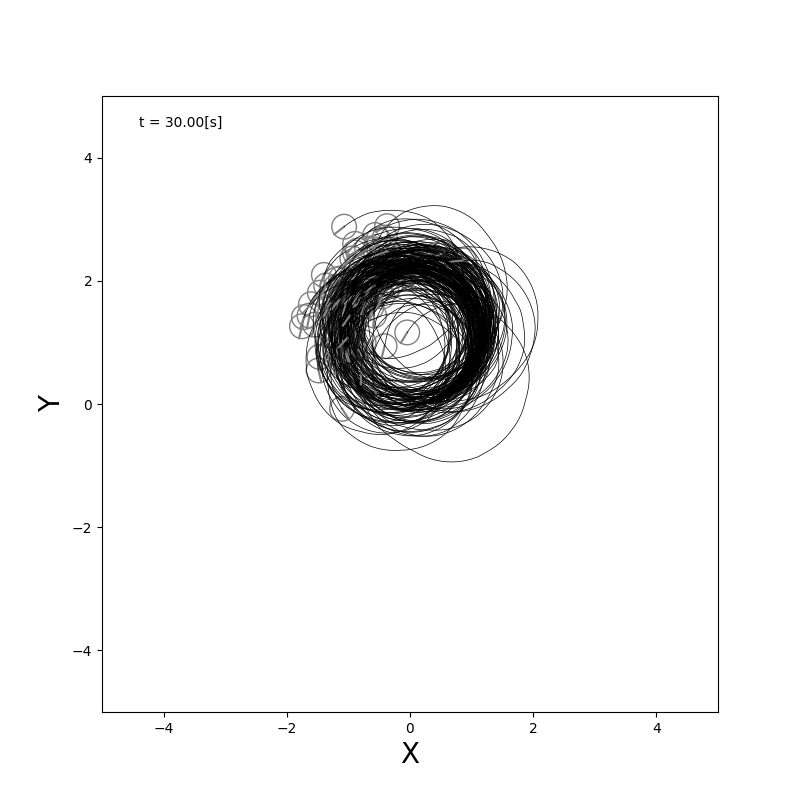

In [12]:
world = World(30, 0.1)

for i in range(100):
    circling = Agent(0.2, 10.0/180*math.pi)
    r = Robot(np.array([0, 0, 0]).T, sensor=None, agent=circling, color="gray")
    world.append(r)
    
world.draw()